In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install mplfinance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.7 MB/s eta 0:00:00


In [3]:
# Basic libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# For processing
import math
import random
import datetime as dt
import matplotlib.dates as mdates

# For visualization
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc

# Libraries for model training
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

In [4]:
import pandas as pd

file_path = "/content/drive/MyDrive/BIG DATA/preprocessed.csv"
df = pd.read_csv(file_path, header='infer')


In [5]:
print(df.columns)

Index(['Unnamed: 0', 'Name', 'Date', 'Open', 'Closing_Price', 'Daily_High',
       'Daily_Low', 'Volume'],
      dtype='object')


In [6]:
df.shape

(97648, 8)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97648 entries, 0 to 97647
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     97648 non-null  int64  
 1   Name           97648 non-null  object 
 2   Date           97648 non-null  object 
 3   Open           97418 non-null  float64
 4   Closing_Price  97646 non-null  float64
 5   Daily_High     97444 non-null  float64
 6   Daily_Low      97444 non-null  float64
 7   Volume         77195 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 6.0+ MB


In [8]:
df.head()

,Unnamed: 0,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume
0,0,Accor,2020-04-03,22.99,23.40,23.40,22.99,67
1,1,Accor,2020-04-02,23.91,22.99,23.91,22.99,250
2,2,Accor,2020-04-01,24.10,23.83,24.10,23.83,37
3,3,Accor,2020-03-31,25.04,25.00,25.24,24.99,336
4,4,Accor,2020-03-30,26.50,25.02,26.50,24.99,415


# **Explorartory Data Analysis**


**Preprocessing**

In [9]:
# Dropping unnecessary column
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [10]:
# Fill missing values in 'Open' with the mean
df['Open'].fillna(df['Open'].mean(), inplace=True)

# Fill missing values in 'Closing_Price' with the median
df['Closing_Price'].fillna(df['Closing_Price'].median(), inplace=True)

# Fill missing values in 'Daily_High' with forward fill method
df['Daily_High'].fillna(method='ffill', inplace=True)

# Fill missing values in 'Daily_Low' with backward fill method
df['Daily_Low'].fillna(method='bfill', inplace=True)

# Fill missing values in 'Volume' with 0 or convert to numeric if it's a string type with errors='coerce'
df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce').fillna(0)


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97648 entries, 0 to 97647
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Name           97648 non-null  object 
 1   Date           97648 non-null  object 
 2   Open           97648 non-null  float64
 3   Closing_Price  97648 non-null  float64
 4   Daily_High     97648 non-null  float64
 5   Daily_Low      97648 non-null  float64
 6   Volume         97648 non-null  float64
dtypes: float64(5), object(2)
memory usage: 5.2+ MB


In [12]:
# Defining a function that will contain stocks data for a specific company
def specific_data(company, start, end):
    company_data = df[df['Name'] == company]
    date_filtered_data = company_data[(company_data['Date'] > start) & (company_data['Date'] < end)]
    return date_filtered_data

In [13]:
import datetime as dt
import random

# Assuming specific_data is a function that filters a DataFrame based on dates
def specific_data(company_name, start_date, end_date):
    # Assuming df is your DataFrame containing the data
    # Filter by company name (Peugeot in this case)
    company_df = df[df['Name'] == company_name]
    # Convert date column to datetime if it's not already
    company_df['Date'] = pd.to_datetime(company_df['Date'])
    # Filter by date range
    specific_df = company_df[(company_df['Date'] >= start_date) & (company_df['Date'] <= end_date)]
    return specific_df

# Setting the start and end date
start_date = dt.datetime(2010, 1, 1)
end_date = dt.datetime(2020, 4, 3)

# Calling our function with Peugeot as the company name
specific_df = specific_data("Peugeot", start_date, end_date)


#add sequence tittle on the dataset


In [14]:
specific_df.head()

,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume
57195,Peugeot,2020-04-03,11.76,11.89,11.97,11.76,40.0
57196,Peugeot,2020-04-02,11.26,11.99,11.99,11.26,660.0
57197,Peugeot,2020-04-01,11.65,11.56,11.83,11.56,875.0
57198,Peugeot,2020-03-31,11.89,12.10,12.14,11.89,0.0
57199,Peugeot,2020-03-30,12.29,11.83,12.29,11.58,0.0


# **Visualization**

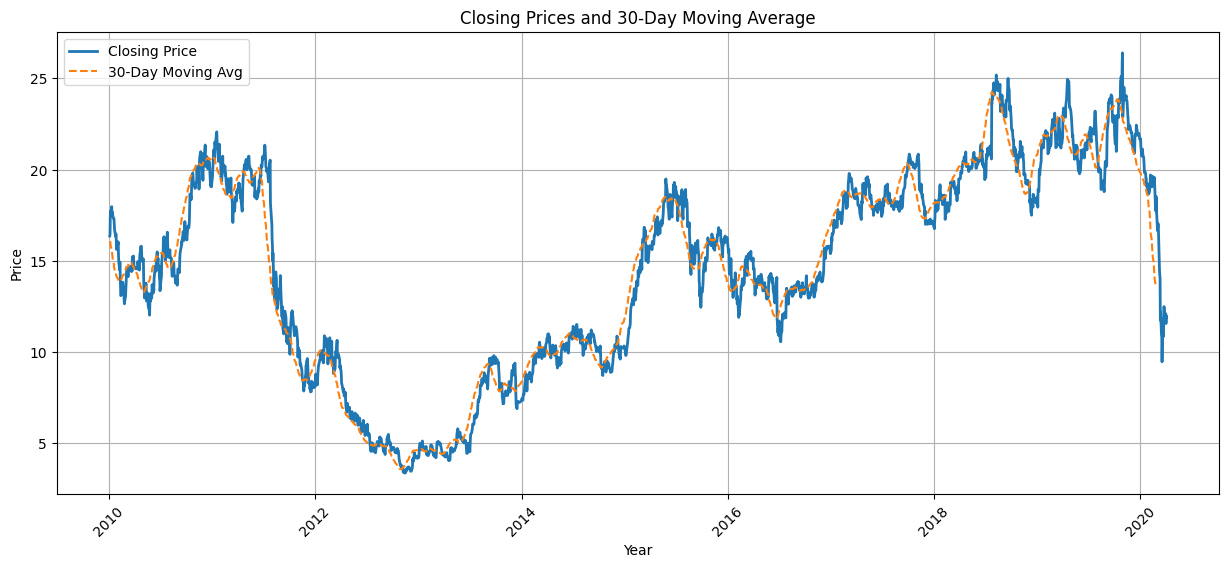

In [15]:
# Closing Prices and Moving Average plot

window = 30
plt.figure(figsize=(15, 6))
plt.plot(specific_df['Date'], specific_df['Closing_Price'], label='Closing Price', linewidth=2)
plt.plot(specific_df['Date'], specific_df['Closing_Price'].rolling(window=window).mean(), label=f'{window}-Day Moving Avg', linestyle='--')
plt.title(f'Closing Prices and {window}-Day Moving Average')
plt.xlabel('Year')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [16]:
specific_df.head()

,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume
57195,Peugeot,2020-04-03,11.76,11.89,11.97,11.76,40.0
57196,Peugeot,2020-04-02,11.26,11.99,11.99,11.26,660.0
57197,Peugeot,2020-04-01,11.65,11.56,11.83,11.56,875.0
57198,Peugeot,2020-03-31,11.89,12.10,12.14,11.89,0.0
57199,Peugeot,2020-03-30,12.29,11.83,12.29,11.58,0.0


In [17]:
new_df = specific_df.reset_index()['Closing_Price']

In [18]:
# Normalizing our data using MinMaxScaler
scaler = MinMaxScaler()
scaled_data=scaler.fit_transform(np.array(new_df).reshape(-1,1))

In [19]:
# Split into training and testing sets
train_size = int(len(scaled_data) * 0.7)  # for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [20]:
# Define the sequence length (number of past time steps)
n_past = 70

# Prepare sequences
X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Similarly prepare sequences for the test set
X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [21]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(1750, 70)
(1750,)


Testing set size:-
(711, 70)
(711,)


(None, None)

In [22]:

# Reshape input data for LSTM([samples, time steps, features])
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# **Model training**

# **Simple RNN**

Epoch 1/10
13/13 [==============================] - 2s 47ms/step - loss: 0.0063 - val_loss: 0.0013
Epoch 2/10
13/13 [==============================] - 0s 23ms/step - loss: 7.1378e-04 - val_loss: 4.0952e-04
Epoch 3/10
13/13 [==============================] - 0s 22ms/step - loss: 4.7740e-04 - val_loss: 2.1726e-04
Epoch 4/10
13/13 [==============================] - 0s 25ms/step - loss: 4.0701e-04 - val_loss: 1.9056e-04
Epoch 5/10
13/13 [==============================] - 0s 22ms/step - loss: 3.8227e-04 - val_loss: 1.8218e-04
Epoch 6/10
13/13 [==============================] - 0s 23ms/step - loss: 3.9071e-04 - val_loss: 1.7453e-04
Epoch 7/10
13/13 [==============================] - 0s 24ms/step - loss: 3.8399e-04 - val_loss: 1.5592e-04
Epoch 8/10
13/13 [==============================] - 0s 25ms/step - loss: 3.5688e-04 - val_loss: 1.4901e-04
Epoch 9/10
13/13 [==============================] - 0s 22ms/step - loss: 3.4889e-04 - val_loss: 1.4075e-04
Epoch 10/10
13/13 [==========================

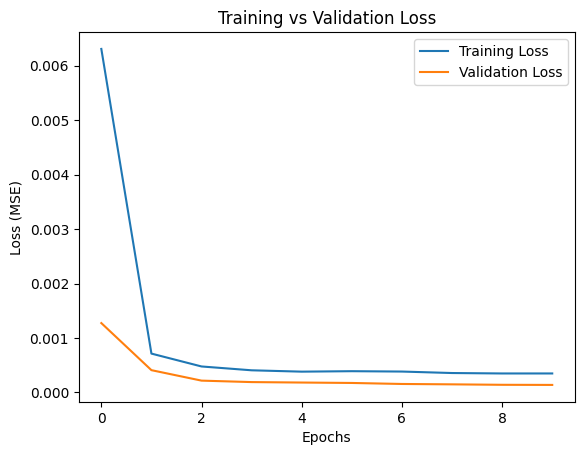

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Initialize a sequential model
model = Sequential()

# Define the model
model_simple_rnn = Sequential([
    SimpleRNN(units=50, activation='tanh', input_shape=(n_past, 1)),
    Dense(units=1)  # Assuming a single output node for regression
])

# Compile the model
model_simple_rnn.compile(optimizer='adam', loss='mse')  # Using mean squared error loss for regression

# Train the model
model_simple_rnn.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.1)  # Example training parameters

# Print model summary
model_simple_rnn.summary()

# Get the training history
history = model_simple_rnn.history

import matplotlib.pyplot as plt

# Plot the training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


In [48]:
model_simple_rnn.compile(loss='mean_squared_error',optimizer='adam')

In [49]:
# Defining our callbacks
checkpoints = ModelCheckpoint(filepath = 'mymodel.h5', save_best_only = True)
# Defining our early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Training our lstm model
model_simple_rnn.fit(X_train, y_train,
          validation_data=(X_test,y_test),
          epochs=10,
          batch_size=32,
          verbose=1,
          callbacks= [checkpoints, early_stopping])

Epoch 1/10
55/55 [==============================] - 2s 24ms/step - loss: 8.6684e-04 - val_loss: 4.0673e-04
Epoch 2/10
55/55 [==============================] - 1s 18ms/step - loss: 3.2658e-04 - val_loss: 3.6905e-04
Epoch 3/10
55/55 [==============================] - 1s 18ms/step - loss: 3.5485e-04 - val_loss: 4.9457e-04
Epoch 4/10
55/55 [==============================] - 1s 18ms/step - loss: 3.3708e-04 - val_loss: 4.0576e-04
Epoch 5/10
55/55 [==============================] - 1s 27ms/step - loss: 2.9566e-04 - val_loss: 3.3508e-04
Epoch 6/10
55/55 [==============================] - 2s 30ms/step - loss: 2.8685e-04 - val_loss: 3.7668e-04
Epoch 7/10
55/55 [==============================] - 2s 30ms/step - loss: 2.9437e-04 - val_loss: 3.2392e-04
Epoch 8/10
55/55 [==============================] - 2s 28ms/step - loss: 3.1520e-04 - val_loss: 3.6632e-04
Epoch 9/10
55/55 [==============================] - 1s 18ms/step - loss: 2.7486e-04 - val_loss: 3.1628e-04
Epoch 10/10
55/55 [==================

In [50]:
# Let's do the prediction and check performance metrics
train_predict=model_simple_rnn.predict(X_train)
test_predict=model_simple_rnn.predict(X_test)

23/23 [==============================] - 0s 6ms/step


In [51]:
# Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)



In [52]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate train data MAE
train_mae = mean_absolute_error(y_train, train_predict)
print("Train MAE:", train_mae)

# Calculate train data MSE
train_mse = mean_squared_error(y_train, train_predict)
print("Train MSE:", train_mse)

# Calculate train data RMSE
print("Train RMSE: ",math.sqrt(mean_squared_error(y_train,train_predict)))

Train MAE: 14.738475282319389
Train MSE: 243.54443277680855
Train RMSE:  15.605910187387614


## **Stacked Simple RNN**

Epoch 1/50
50/50 [==============================] - 5s 68ms/step - loss: 0.0232 - val_loss: 0.0028
Epoch 2/50
50/50 [==============================] - 3s 64ms/step - loss: 0.0013 - val_loss: 0.0060
Epoch 3/50
50/50 [==============================] - 2s 34ms/step - loss: 0.0010 - val_loss: 0.0023
Epoch 4/50
50/50 [==============================] - 2s 34ms/step - loss: 8.3950e-04 - val_loss: 7.8801e-04
Epoch 5/50
50/50 [==============================] - 2s 35ms/step - loss: 7.8931e-04 - val_loss: 5.2228e-04
Epoch 6/50
50/50 [==============================] - 2s 35ms/step - loss: 7.5629e-04 - val_loss: 8.8517e-04
Epoch 7/50
50/50 [==============================] - 2s 33ms/step - loss: 6.3145e-04 - val_loss: 5.4050e-04
Epoch 8/50
50/50 [==============================] - 2s 41ms/step - loss: 5.9745e-04 - val_loss: 5.9140e-04
Epoch 9/50
50/50 [==============================] - 3s 62ms/step - loss: 5.6752e-04 - val_loss: 3.5465e-04
Epoch 10/50
50/50 [==============================] - 2s 47ms/

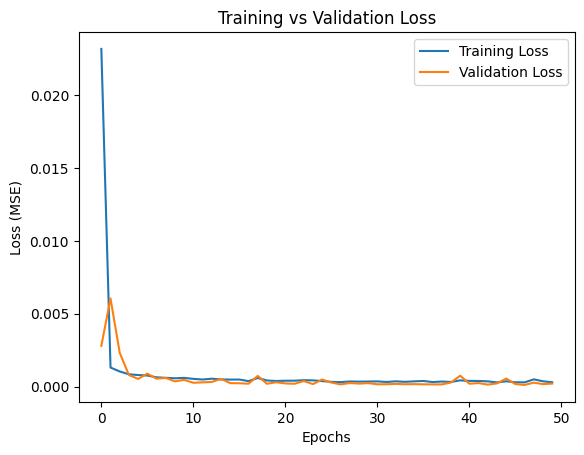

In [53]:
# Define the model
model_stacked_simple_rnn = Sequential([
    SimpleRNN(units=50, activation='tanh', return_sequences=True, input_shape=(n_past, 1)),
    SimpleRNN(units=50, activation='tanh'),
    Dense(units=1)  # Third Dense layer for regression
])

# Compile the model
model_stacked_simple_rnn.compile(optimizer='adam', loss='mse')  # Using mean squared error loss for regression

# Train the model
model_stacked_simple_rnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)  # Example training parameters

# Print model summary
model_stacked_simple_rnn.summary()

# Get the training history
history = model_stacked_simple_rnn.history

import matplotlib.pyplot as plt

# Plot the training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


In [54]:
model_stacked_simple_rnn.compile(loss='mean_squared_error',optimizer='adam')

In [55]:
# Defining our callbacks
checkpoints = ModelCheckpoint(filepath = 'mymodel.h5', save_best_only = True)
# Defining our early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Training our lstm model
model_stacked_simple_rnn.fit(X_train, y_train,
          validation_data=(X_test,y_test),
          epochs=50,
          batch_size=32,
          verbose=1,
          callbacks= [checkpoints, early_stopping])



Epoch 1/50
55/55 [==============================] - 5s 48ms/step - loss: 0.0014 - val_loss: 3.5953e-04
Epoch 2/50
55/55 [==============================] - 4s 67ms/step - loss: 2.6206e-04 - val_loss: 3.0674e-04
Epoch 3/50
55/55 [==============================] - 3s 59ms/step - loss: 2.6475e-04 - val_loss: 2.8663e-04
Epoch 4/50
55/55 [==============================] - 2s 39ms/step - loss: 3.1556e-04 - val_loss: 4.5968e-04
Epoch 5/50
55/55 [==============================] - 2s 39ms/step - loss: 3.2199e-04 - val_loss: 4.2541e-04
Epoch 6/50
55/55 [==============================] - 2s 37ms/step - loss: 2.7435e-04 - val_loss: 6.1952e-04
Epoch 7/50
55/55 [==============================] - 2s 37ms/step - loss: 3.8108e-04 - val_loss: 4.9725e-04
Epoch 8/50
55/55 [==============================] - 3s 59ms/step - loss: 2.7871e-04 - val_loss: 3.3685e-04
Epoch 9/50
55/55 [==============================] - 4s 75ms/step - loss: 3.6615e-04 - val_loss: 2.9699e-04
Epoch 10/50
55/55 [======================

In [56]:
# Let's do the prediction and check performance metrics
train_predict=model_stacked_simple_rnn.predict(X_train)
test_predict=model_stacked_simple_rnn.predict(X_test)

23/23 [==============================] - 0s 11ms/step


In [57]:
# Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)


In [58]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate train data MAE
train_mae = mean_absolute_error(y_train, train_predict)
print("Train MAE:", train_mae)

# Calculate train data MSE
train_mse = mean_squared_error(y_train, train_predict)
print("Train MSE:", train_mse)

# Calculate train data RMSE
print("Train RMSE: ",math.sqrt(mean_squared_error(y_train,train_predict)))




Train MAE: 14.7797100043206
Train MSE: 244.71374285605512
Train RMSE:  15.643329020897538


# **LSTM Method**

In [59]:
# Initialize a sequential model
model = Sequential()

# First LSTM layer with 50 units, input shape, and return sequences
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))         # Adding dropout to prevent overfitting

# Second LSTM layer with 50 units and return sequences
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Third LSTM layer with 50 units
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Add a dense output layer with one unit
model.add(Dense(units=1))
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 70, 50)            10400     
                                                                 
 dropout_3 (Dropout)         (None, 70, 50)            0         
                                                                 
 lstm_4 (LSTM)               (None, 70, 50)            20200     
                                                                 
 dropout_4 (Dropout)         (None, 70, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [60]:
model.compile(loss='mean_squared_error',optimizer='adam')

Epoch 1/50
55/55 [==============================] - 16s 155ms/step - loss: 0.0214 - val_loss: 0.0024
Epoch 2/50
55/55 [==============================] - 8s 152ms/step - loss: 0.0049 - val_loss: 0.0026
Epoch 3/50
55/55 [==============================] - 6s 117ms/step - loss: 0.0046 - val_loss: 0.0022
Epoch 4/50
55/55 [==============================] - 9s 173ms/step - loss: 0.0042 - val_loss: 0.0022
Epoch 5/50
55/55 [==============================] - 6s 118ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 6/50
55/55 [==============================] - 9s 173ms/step - loss: 0.0042 - val_loss: 0.0020
Epoch 7/50
55/55 [==============================] - 7s 128ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 8/50
55/55 [==============================] - 9s 165ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 9/50
55/55 [==============================] - 7s 129ms/step - loss: 0.0037 - val_loss: 0.0029
Epoch 10/50
55/55 [==============================] - 9s 159ms/step - loss: 0.0038 - val_loss: 0.001

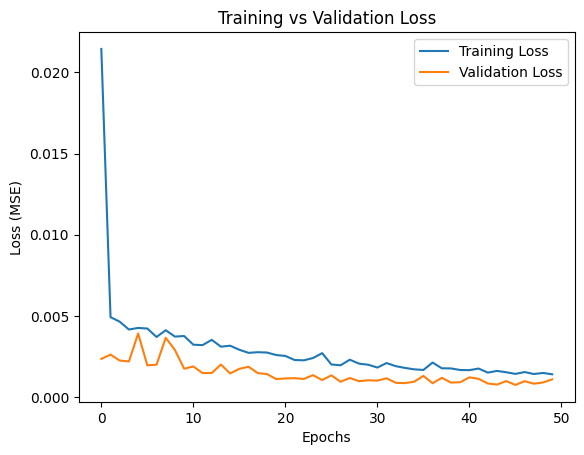

In [61]:
# Defining our callbacks
checkpoints = ModelCheckpoint(filepath = 'mymodel.h5', save_best_only = True)
# Defining our early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Training our lstm model
model.fit(X_train, y_train,
          validation_data=(X_test,y_test),
          epochs=50,
          batch_size=32,
          verbose=1,
          callbacks= [checkpoints, early_stopping])

# Get the training history
history = model.history

import matplotlib.pyplot as plt


# Plot the training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()





In [65]:
 # Let's do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

23/23 [==============================] - 1s 31ms/step


In [66]:
# Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [67]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate train data MAE
train_mae = mean_absolute_error(y_train, train_predict)
print("Train MAE:", train_mae)

# Calculate train data MSE
train_mse = mean_squared_error(y_train, train_predict)
print("Train MSE:", train_mse)

# Calculate train data RMSE
print("Train RMSE: ",math.sqrt(mean_squared_error(y_train,train_predict)))




Train MAE: 14.361534403996243
Train MSE: 229.31808084403772
Train RMSE:  15.143251990376365


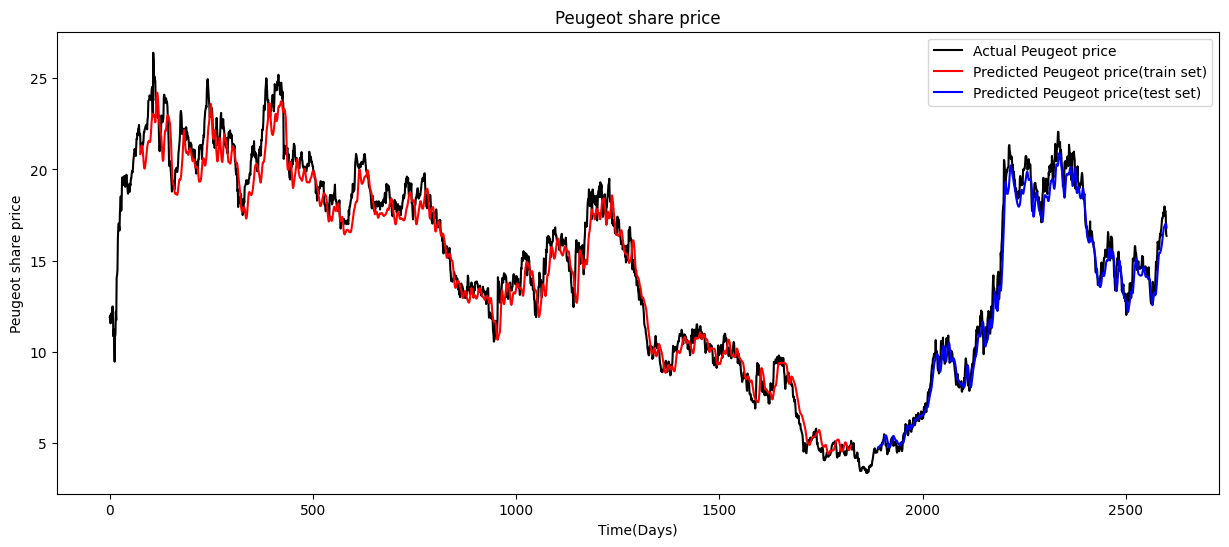

In [68]:
# Set the number of previous time steps to consider for plotting
look_back = 75

# Initialize an array for plotting the train predictions
trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:] = np.nan
# Assign the predicted values to the appropriate location for train predictions
trainPredictPlot[look_back:len(train_predict)+look_back] = train_predict.flatten()

# Initialize an array for plotting the test predictions
testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
# Calculate the starting index for the test predictions
test_start = len(new_df) - len(test_predict)
# Assign the predicted values to the appropriate location for test predictions
testPredictPlot[test_start:] = test_predict.flatten()

# Rescale the scaled data back to its original scale using the scaler
original_scaled_data = scaler.inverse_transform(scaled_data)

# Plotting the baseline data, training predictions, and test predictions
plt.figure(figsize=(15, 6))
plt.plot(original_scaled_data, color='black', label=f"Actual Peugeot price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted Peugeot price(train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted Peugeot price(test set)")

plt.title(f"Peugeot share price")
plt.xlabel("Time(Days)")
plt.ylabel(f"Peugeot share price")
plt.legend()
plt.show()


In [69]:
# To predict for the next 10 days, you'll need the last n_past days of data
last_sequence = X_test[-1]

# Reshape the last_sequence to match the input shape of the model
last_sequence = last_sequence.reshape(1, n_past, 1)

# Generate predictions for the next 10 days
predictions_next_10_days = []
for _ in range(10):
    next_day_prediction = model.predict(last_sequence)
    predictions_next_10_days.append(next_day_prediction[0, 0])  # Get the predicted value
    last_sequence = np.roll(last_sequence, -1, axis=1)  # Shift the sequence by one day
    last_sequence[0, -1, 0] = next_day_prediction  # Update the last element with the new prediction

# Transform the predictions back to the original scale
predictions_next_10_days = scaler.inverse_transform(np.array(predictions_next_10_days).reshape(-1, 1))

# Print the predictions for the next 10 days
print("Predictions for the next 10 days:")
for i, prediction in enumerate(predictions_next_10_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")

1/1 [==============================] - 0s 35ms/step
Predictions for the next 10 days:
Day 1: Predicted Price = 16.819578170776367
Day 2: Predicted Price = 16.575746536254883
Day 3: Predicted Price = 16.325666427612305
Day 4: Predicted Price = 16.087308883666992
Day 5: Predicted Price = 15.865229606628418
Day 6: Predicted Price = 15.65941333770752
Day 7: Predicted Price = 15.468832015991211
Day 8: Predicted Price = 15.292490005493164
Day 9: Predicted Price = 15.129461288452148
Day 10: Predicted Price = 14.978779792785645


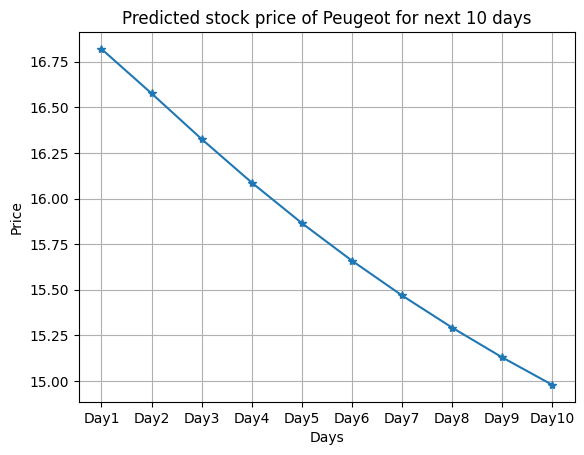

In [70]:
plt.plot(predictions_next_10_days, marker='*')
plt.title(f'Predicted stock price of Peugeot for next 10 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 10), ['Day1', 'Day2', 'Day3', 'Day4', 'Day5', 'Day6', 'Day7', 'Day8', 'Day9', 'Day10'])
plt.grid(True)
plt.show()